In [1]:
# jupyter nbconvert gkf_data.ipynb --no-input --to html

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from dateutil.relativedelta import relativedelta
import calendar

In [2]:
import plotly
plotly.offline.init_notebook_mode()

In [3]:
df = pd.read_csv("../gfk_analysis/raw_data/GFK_CUSTOMREPORT_TRUCKTIRE_TW_BRIDGESTONE_Mar22.csv")

In [ ]:
speedindex = df["SPEEDINDEX"].str.split(" ", expand=True).reset_index(name="Index")

## 終端價格趨勢
- 按照品牌、花紋、規格
- 計算每個花紋上市時間

In [4]:
df["FirstActivity"] = pd.to_datetime(df["FirstActivity"], yearfirst=True)
df["Period"] = pd.to_datetime(df["Period"], yearfirst=True)

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 1-03-22 00:00:00

In [ ]:
(df["Period"] - df["FirstActivity"]).dt.

In [ ]:
df = df.astype({"SALES UNITS": "int", "SALES <LC>": "int", "PRICE TWD/UN.": "int"})

In [ ]:
from datetime import datetime

In [ ]:
df["LifeCycle"] = round(((datetime.today() - df["FirstActivity"]).dt.days) / 365, 1)

In [ ]:
df["LifeCycle"].sort_values(ascending=True)

## 2022年當月數據對比YoY

'REPORTINGPRODUCTGROUP': 產品別（可以drop）, 'COUNTRY': 可以drop, 'REPORTINGCHANNEL': Panel market（可drop）, 
'Period': date, 'Item': Model name, 'BRAND': Brand name, 'REGION': 北中南區, 'BRIDGESTONE TYPE': 普利司通產品分類,
'DIMENSION (Truck Tyres)':輪胎規格, 'RIMDIAMET.'/MM':直徑, 'WIDTH IN INCH':胎寬（英吋）,'WIDTH IN MM':胎寬（公厘）,
'ASPECT RATIO': 扁平比, 'TUBE / TUBLESS': 是否有內胎, 'LOADINDEX': 荷重指數, 'FirstActivity': 首次上市時間？,
'SALES UNITS': 銷售數量, 'SALES <LC>': 銷售額, 'PRICE TWD/UN.':單價

In [ ]:
date = datetime.today().strftime("%Y-%m-%d")

In [ ]:
date = datetime.strptime(date, "%Y-%m-%d")

In [ ]:
interval = date - relativedelta(months=14)

In [ ]:
interval = interval.strftime("%Y-%m")

In [ ]:
gfk = df.copy()

In [ ]:
gfk["Period"] = pd.to_datetime(gfk["Period"], yearfirst=True)
# gfk["Period"] = gfk["Period"].dt.to_period("M")
gfk["Period"] = gfk["Period"].dt.strftime("%Y-%m")

In [ ]:
# 日期列表建立
# date_order = gfk["Period"].sort_values().unique().tolist()

In [ ]:
# gfk["Period"] = pd.Categorical(gfk["Period"], ordered=True, categories=date_order)

In [ ]:
filtered_data = gfk[gfk["Period"] >= interval]

## 將Top 10以外的分類出來

In [ ]:
top10_players = ["BRIDGESTONE", "MAXXIS", "MICHELIN", "LINGLONG", "JINYUTIRES", "PRESA", "DUNLOP", "GOODYEAR", "YOKOHAMA"]
filtered_data["PLAYERS"] = filtered_data["BRAND"].map(lambda x: "The others" if x not in top10_players else x)

## 數值格式調整

In [ ]:
filtered_data = filtered_data.astype({"SALES UNITS": "int", "SALES <LC>": "int", "PRICE TWD/UN.": "int"})

## 分組資料

In [ ]:
bar_sales_units = filtered_data.groupby(["Period", "BRIDGESTONE TYPE"])[["SALES UNITS"]].sum().reset_index()
bar_sales_units = bar_sales_units.sort_values(by="SALES UNITS", ascending=False)
bar_sales_units["in %"] = 100 * (bar_sales_units["SALES UNITS"] / bar_sales_units.groupby("Period")["SALES UNITS"].transform("sum"))

In [ ]:
px.bar(bar_sales_units, x="Period", y="SALES UNITS", color="BRIDGESTONE TYPE", text=bar_sales_units["in %"].map(lambda x: "{:.0f}%".format(x)), title="Truck tires sales units")

In [ ]:
filtered_data[filtered_data["BRIDGESTONE TYPE"] != "EXCLUDED TBR AND LSR2"].groupby(["Period", "BRIDGESTONE TYPE"])[["SALES UNITS"]].sum().unstack("Period").reset_index()

## 文字敘述
- a. 本月 vs 上月 %， vs 去年同期 %
- b. 今年累計 vs 去年同期累計 %

### a點實作

In [ ]:
gfk_numbers = filtered_data.groupby(["Period"])[["SALES UNITS"]].sum().reset_index()

In [ ]:
previous_mon = int(datetime.today().strftime("%m")) - 1
before_pre_mon = previous_mon - 1

In [ ]:
month_names = [calendar.month_name[i] for i in range(1, 13)]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
month_dict = dict(zip(months, month_names))

In [ ]:
gfk_numbers.iloc[-1, 1] / gfk_numbers.iloc[0, 1]

In [ ]:
month_dict[previous_mon] + " vs " + month_dict[before_pre_mon] + " " + "{:.0f}%".format(100 * gfk_numbers.iloc[-1, 1] / gfk_numbers.iloc[-2, 1]) + " , vs PY " + "{:.0f}%".format(100 * gfk_numbers.iloc[-1, 1] / gfk_numbers.iloc[0, 1])

### b點實作

In [ ]:
current_year = datetime.today().strftime("%Y")

In [ ]:
# 檢查目前今年的資料是幾個月的
cum_months = len(gfk_numbers[gfk_numbers["Period"].str.contains(current_year)])

In [ ]:
# 今年累計數量
ytd_units = gfk_numbers[gfk_numbers["Period"].str.contains(current_year)]["SALES UNITS"].sum()

In [ ]:
# 去年累計數量
py_units = gfk_numbers[gfk_numbers["Period"].str.contains(str(cum_months - 1))]["SALES UNITS"][0:cum_months].sum()

In [ ]:
"b. YTD vs PY " + "{:.0f}%".format(100 * ytd_units / py_units)

## 每季銷售

In [ ]:
df = df.astype({"SALES UNITS": "int", "SALES <LC>": "int", "PRICE TWD/UN.": "int"})

In [ ]:
df["Period"] = pd.to_datetime(df["Period"], dayfirst=True)

In [ ]:
qt_data = df.groupby([pd.Grouper(key="Period", freq="QS"), "BRIDGESTONE TYPE"])[["SALES UNITS"]].sum().reset_index()

In [ ]:
qt_data["Year"] = qt_data["Period"].dt.year
qt_data["Quarter"] = qt_data["Period"].dt.quarter

In [ ]:
qt_data = qt_data.astype({"Year": "str", "Quarter": "str"})

In [ ]:
qt_data["Y+Q"] = qt_data["Year"] + "Q" + qt_data["Quarter"]

In [ ]:
qt_data["in %"] = 100 * (qt_data["SALES UNITS"] / qt_data.groupby("Period")["SALES UNITS"].transform("sum"))

In [ ]:
px.bar(qt_data, x="Y+Q", y="SALES UNITS", color="BRIDGESTONE TYPE", text=qt_data["in %"].map(lambda x: "{:.0f}%".format(x)), labels={"Y+Q": "Quarter"})

In [ ]:
qt_data[qt_data["BRIDGESTONE TYPE"] != "EXCLUDED TBR AND LSR2"].groupby(["Y+Q", "BRIDGESTONE TYPE"])[["SALES UNITS"]].sum().unstack("Y+Q").reset_index()

In [ ]:
bar_sales_units = filtered_data.groupby(["Period", "PLAYERS"])[["SALES UNITS"]].sum().reset_index()
bar_sales_units = bar_sales_units.sort_values(by="SALES UNITS", ascending=False)
bar_sales_units["in %"] = 100 * (bar_sales_units["SALES UNITS"] / bar_sales_units.groupby("Period")["SALES UNITS"].transform("sum"))

In [ ]:
px.bar(bar_sales_units, x="Period", y="SALES UNITS", color="PLAYERS", text=bar_sales_units["in %"].map(lambda x: "{:.1f}%".format(x)), title="Truck tires sales units")

In [ ]:
filtered = gfk[(gfk["Period"] == "JANUARY 2022") & (gfk["BRIDGESTONE TYPE"] == "TBR")]

In [ ]:
filtered["b_name"] = filtered["BRAND"].map(lambda x: "Others" if x not in ["MICHELIN", "BRIDGESTONE", "MAXXIS"] else x)

In [ ]:
px.scatter(filtered, x="DIMENSION (Truck Tyres)", y="PRICE TWD/UN.", color="b_name", marginal_y="box", marginal_x="histogram", title="Sell-out價格分佈圖")

In [ ]:
r150 = gfk[(gfk["Period"] == "JANUARY 2022") & (gfk["DIMENSION (Truck Tyres)"] == "12.00/22.5")]

In [ ]:
r150.groupby(["BRAND", "Item"])[["PRICE TWD/UN."]].mean()

In [ ]:
tbr = gfk[(gfk["Period"].str.contains("2021")) & (gfk["BRIDGESTONE TYPE"] == "TBR")]

In [ ]:
tbr_filtered = tbr.groupby(["DIMENSION (Truck Tyres)"])[["SALES UNITS"]].sum().reset_index().sort_values(by="SALES UNITS", ascending=False)

## Plotly graph_objects practice

In [15]:
df["Period_Revised"] = df["Period"].map(lambda x: "20" + x[-2:] + "-" + x[0:3] + "22")

In [16]:
df["Period"] = pd.to_datetime(df["Period_Revised"], yearfirst=True)

In [21]:
df["BRAND"] = df["BRAND"].map(lambda x: "Others" if x not in ["MAXXIS", "MICHELIN", "BRIDGESTONE", "LINGLONG"] else x)

In [22]:
df.columns

Index(['REPORTINGPRODUCTGROUP', 'COUNTRY', 'REPORTINGCHANNEL', 'Period',
       'Item', 'BRAND', 'REGION', 'BRIDGESTONE TYPE',
       'DIMENSION (Truck Tyres)', 'RIMDIAMET.'/MM', 'WIDTH IN INCH',
       'WIDTH IN MM', 'ASPECT RATIO', 'TUBE / TUBLESS', 'LOADINDEX',
       'SPEEDINDEX', 'FirstActivity', 'SALES UNITS', 'SALES <LC>',
       'PRICE TWD/UN.', 'Period_Revised'],
      dtype='object')

In [80]:
# 處理極端值
df = df[~(df["PRICE TWD/UN."] >= 90000)]

## 次數分配

In [23]:
df["PRICE TWD/UN."] = df["PRICE TWD/UN."].astype(int)

In [24]:
df["Year"] = df["Period"].dt.year

In [25]:
x = df[(df["BRAND"] == "BRIDGESTONE") & (df["Year"] == 2021)]

In [26]:
y = df[(df["BRAND"] == "BRIDGESTONE") & (df["Year"] == 2022) & (df["BRIDGESTONE TYPE"] == "TBR") & (df["RIMDIAMET.\'/MM"].str.contains("22.5"))]

### Outlier
1. IQR = Q3 - Q1
2. Fence = Q1 - 1.5 * IQR(lower fence), Q3 + 1.5 * IQR(Upper fence)
- It means the values that exceed the fences are outliers, need to check the status.

In [27]:
a = px.histogram(y, x="PRICE TWD/UN.", color="REGION", nbins=10, marginal="box")

## Treemap of products distribution 

In [81]:
tree = y.groupby(["Period", "REGION", "Item", "DIMENSION (Truck Tyres)"])[["SALES UNITS", "PRICE TWD/UN."]].agg({"SALES UNITS": "sum", "PRICE TWD/UN.": "mean"}).reset_index()

In [82]:
tree["PRICE TWD/UN."] = tree["PRICE TWD/UN."].astype(int)

In [83]:
tree["SALES UNITS"] = tree["SALES UNITS"].astype(int)

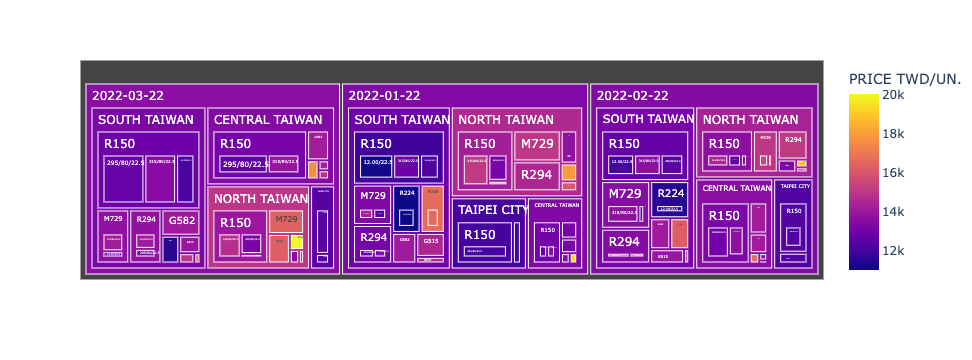

In [84]:
px.treemap(tree, path=["Period", "REGION", "Item", "DIMENSION (Truck Tyres)"], values="SALES UNITS", color="PRICE TWD/UN.")

### Bar plot with graph objects

In [85]:
df = df[df["Period"] >= "2021-01-01"]

In [86]:
df["SALES UNITS"] = df["SALES UNITS"].astype(int)

In [87]:
quar = df.groupby([pd.Grouper(key="Period", freq="QS"), "BRAND"])[["SALES UNITS"]].sum().reset_index()

In [88]:
quar["SALES UNITS in %"] = 100 * quar["SALES UNITS"] / quar.groupby("Period")["SALES UNITS"].transform("sum")

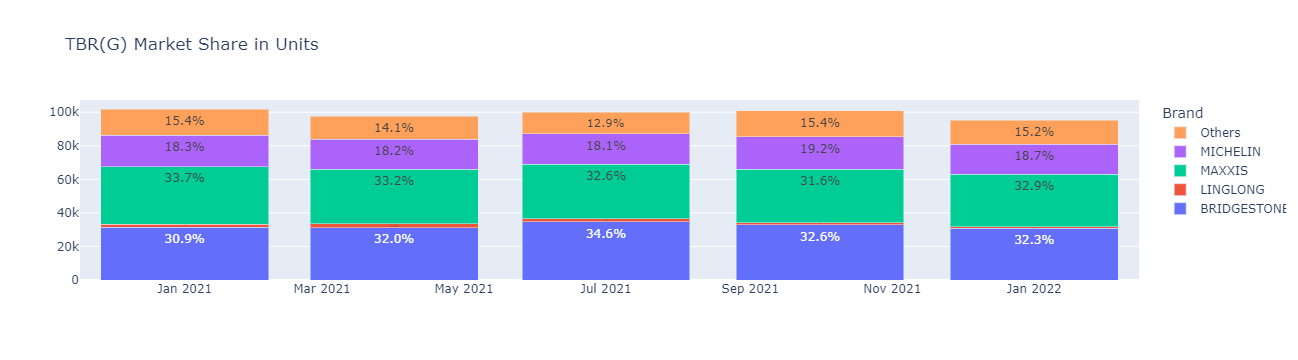

In [89]:
quar_fig = go.Figure()
for brand, value in quar.groupby("BRAND"):
    quar_fig.add_trace(go.Bar(x=value["Period"], y=value["SALES UNITS"], name=brand, text=value["SALES UNITS in %"].map(lambda x: "{:.1f}%".format(x)), textposition="inside", legendgroup="group"))
quar_fig.update_layout(legend_title_text = "Brand", barmode="stack", title="TBR(G) Market Share in Units")
quar_fig.show()

In [90]:
test = df.groupby([pd.Grouper(key="Period", freq="MS"), "BRAND"])[["SALES UNITS"]].sum().reset_index()

In [91]:
test["SALES UNITS"] = test["SALES UNITS"].astype(int)

In [92]:
test["SALES UNITS in %"] = 100 * test["SALES UNITS"] / test.groupby("Period")["SALES UNITS"].transform("sum")

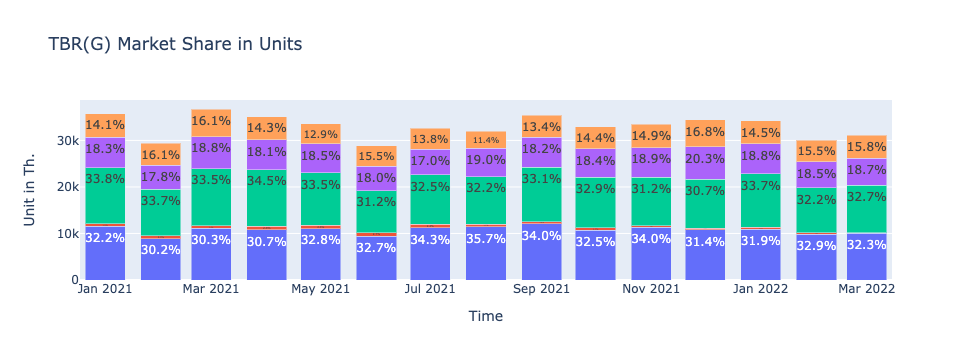

In [93]:
fig = go.Figure()
for period, value in test.groupby("BRAND"): # period是groupby中BRAND的名字，value是要輸出的內容
    fig.add_trace(go.Bar(x=value["Period"], y=value["SALES UNITS"], name=period, text=value["SALES UNITS in %"].map(lambda x: "{:.1f}%".format(x)), textposition="inside", legendgroup="group", showlegend=False))
fig.update_layout(legend_title_text = "Brand", barmode="stack", title="TBR(G) Market Share in Units")
fig.update_xaxes(title_text="Time")
fig.update_yaxes(title_text="Unit in Th.")
fig.show()

In [94]:
df["Month"] = df["Period"].dt.month_name()
df["Year"] = df["Period"].dt.year

In [95]:
fir_q = df[df["Month"].isin(["January", "February", "March"])]

In [96]:
fir_q = fir_q.groupby([pd.Grouper(key="Period", freq="QS"), "BRAND"])[["SALES UNITS"]].sum().reset_index()

In [97]:
fir_q["SALES UNITS in %"] = 100 * fir_q["SALES UNITS"] / fir_q.groupby("Period")["SALES UNITS"].transform("sum")

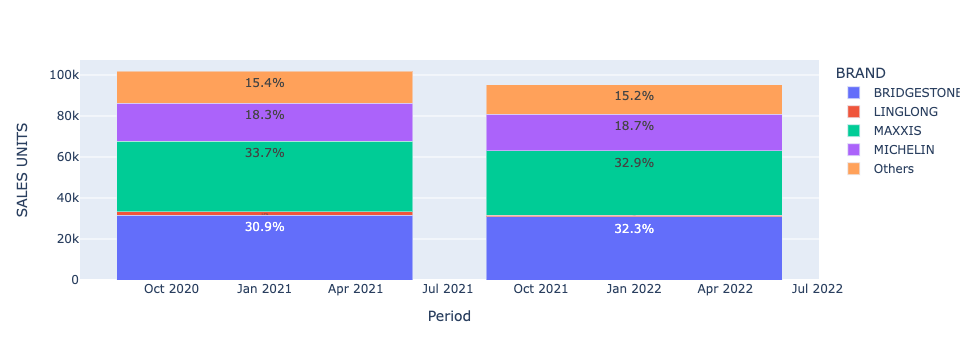

In [98]:
px.bar(fir_q, x="Period", y="SALES UNITS", barmode="stack", color="BRAND", text=fir_q["SALES UNITS in %"].map(lambda x: "{:.1f}%".format(x)), width=320)

### Plotly px facets by district and row with sales volume and revenue

In [99]:
district_data = df.groupby([pd.Grouper(key="Period", freq="M"), "BRAND", "BRIDGESTONE TYPE", "REGION"])[["SALES UNITS", "SALES <LC>"]].sum().reset_index()

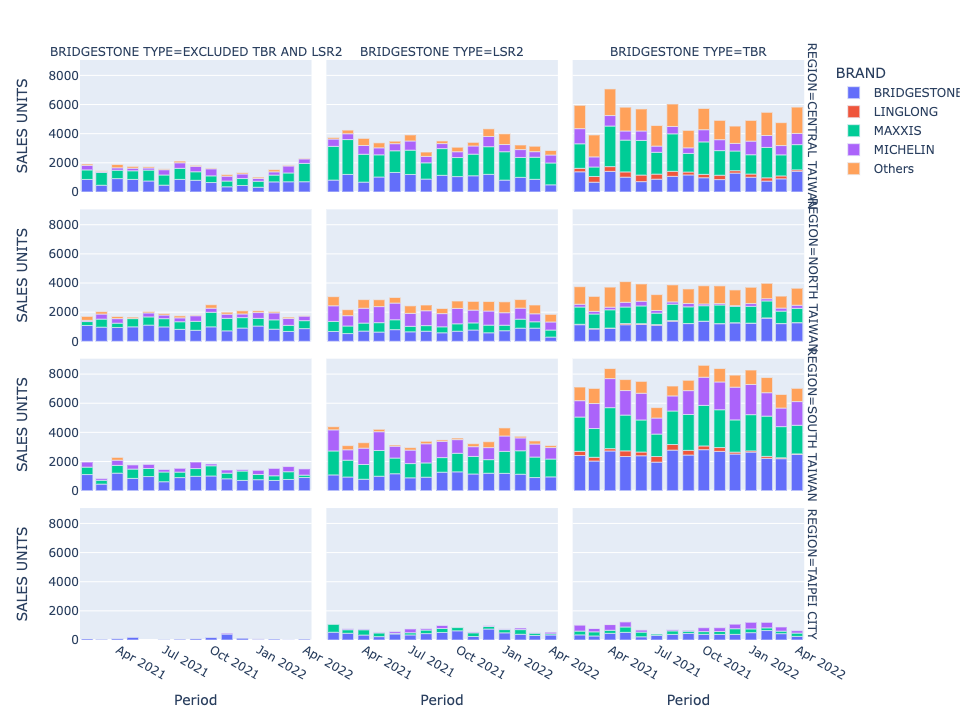

In [100]:
px.bar(district_data, x="Period", y="SALES UNITS", color="BRAND", facet_row="REGION", facet_col="BRIDGESTONE TYPE", height=720)

### Average sell-out price by District and BRIDGESTONE TYPE

In [101]:
district_data["Average sell-out price"] = district_data["SALES <LC>"] / district_data["SALES UNITS"]

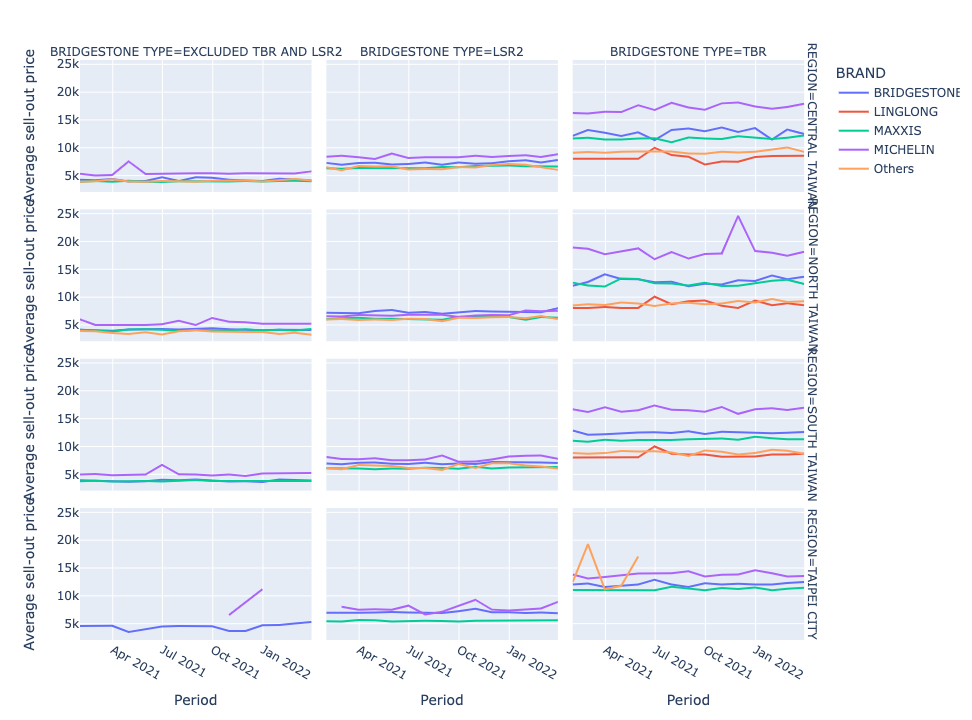

In [102]:
px.line(district_data, x="Period", y="Average sell-out price", color="BRAND", facet_col="BRIDGESTONE TYPE", facet_row="REGION", height=720)

### 按照尺寸別去分析

In [113]:
dimension = df["SALES UNITS"].groupby([df["Period"], df["BRIDGESTONE TYPE"], df["DIMENSION (Truck Tyres)"]]).sum().reset_index()

In [114]:
dimension["SALES UNITS"] = dimension["SALES UNITS"].astype(int)

In [115]:
dimension["SALES UNITS in %"] = 100 * dimension["SALES UNITS"] / dimension.groupby(["Period", "BRIDGESTONE TYPE"])["SALES UNITS"].transform("sum")

In [106]:
tbr = dimension[dimension["BRIDGESTONE TYPE"] == "TBR"]

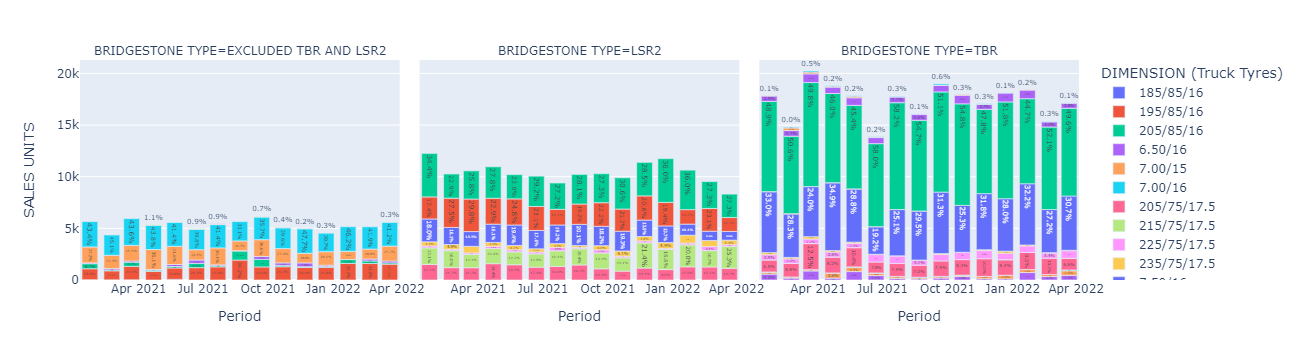

In [117]:
px.bar(dimension, x="Period", y="SALES UNITS", color="DIMENSION (Truck Tyres)" , text=dimension["SALES UNITS in %"].map(lambda x: "{:.1f}%".format(x)), facet_col="BRIDGESTONE TYPE")

In [13]:
from plotly.subplots import make_subplots

In [189]:
sub_p = make_subplots(rows=2, cols=2, specs=[[{"type": "xy"}, {}], [{"colspan": 2}, None]], subplot_titles=("1", "2", "3"))

In [112]:
t1 = []
t2 = []
for t in range(len(a["data"])):
    t1.append(a["data"][t])
for x in range(len(b["data"])):
    t2.append(b["data"][x])

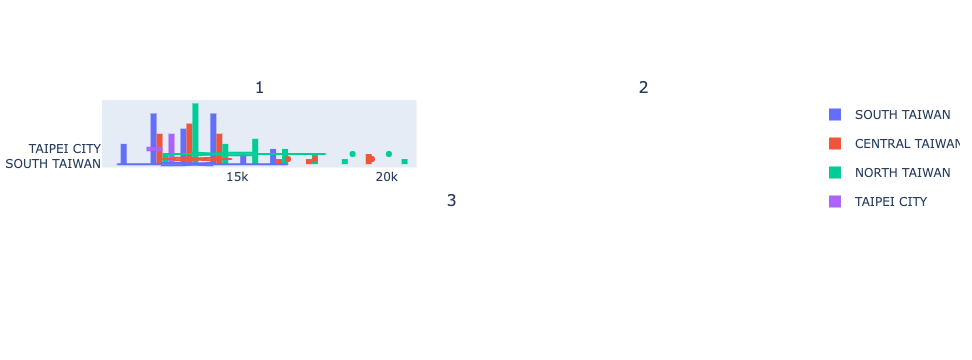

In [113]:
for traces in t1:
    sub_p.append_trace(traces, row=1, col=1)
# for traces in t2:
#     sub_p.append_trace(traces, row=1, col=2)

sub_p.show()



In [240]:
tes_p = make_subplots(rows=1, cols=2, specs=[[{"type":"bar"}, {"type": "bar"}]])

In [241]:
t1 = []
t2 = []
for t in range(len(fig["data"])):
    t1.append(fig["data"][t])
for x in range(len(quar_fig["data"])):
    t2.append(quar_fig["data"][x])

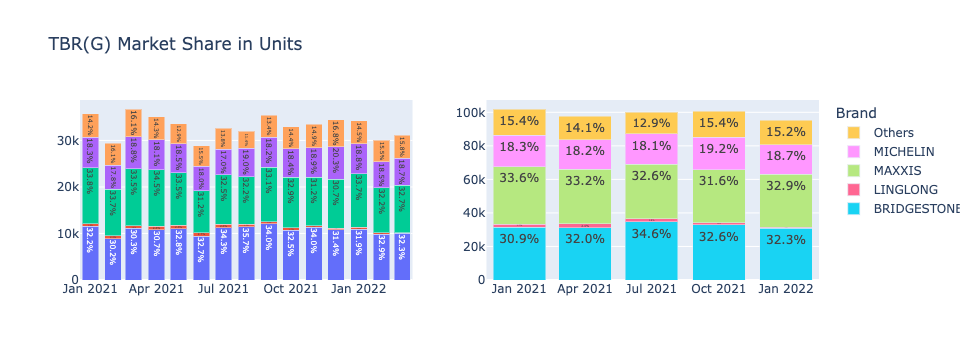

In [242]:
for traces in t1:
    tes_p.append_trace(traces, row=1, col=1)
for traces in t2:
    tes_p.append_trace(traces, row=1, col=2)
tes_p.update_layout(legend_title_text = "Brand", barmode="stack", title="TBR(G) Market Share in Units")

tes_p.show()

## 測試bar+line

In [73]:
subfig = make_subplots(specs=[[{"secondary_y": True}]])

In [74]:
test = df.groupby([pd.Grouper(key="Period", freq="MS"), "BRAND"])[["SALES UNITS"]].sum().reset_index()

In [75]:
test2 = df.groupby([pd.Grouper(key="Period", freq="MS"), "BRAND"])[["PRICE TWD/UN."]].mean().reset_index()

In [76]:
t_fig = px.bar(test, x="Period", y="SALES UNITS", color="BRAND", barmode="stack", text="SALES UNITS")

In [77]:
t_fig2 = px.line(test2, x="Period", y="PRICE TWD/UN.", color="BRAND")

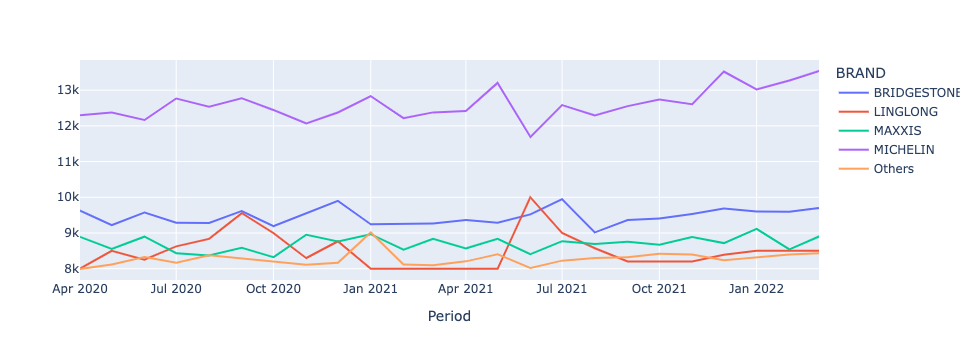

In [78]:
t_fig2.update_traces(yaxis="y2")

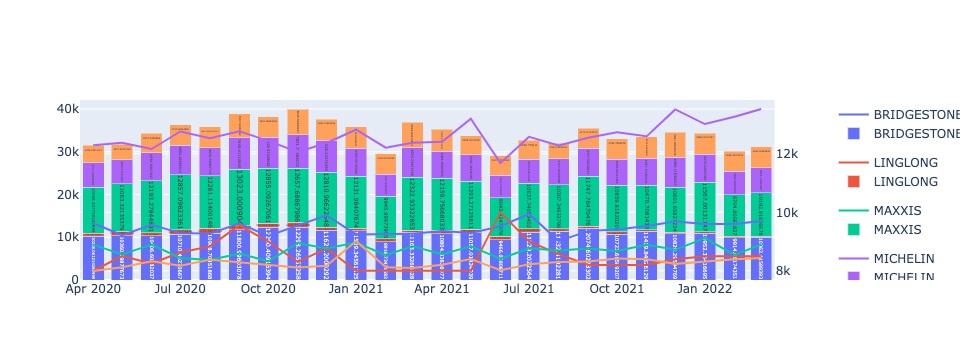

In [79]:
subfig.add_traces(t_fig.data + t_fig2.data)
subfig.update_layout(barmode="stack", width=1280)

## 測試mitosheet
- 製作圖表的時候自由度太低，長條圖沒有辦法選擇類型，只能用群組長條圖
- Goupby功能要用pivot table去實現，有點難用

In [19]:
import mitosheet

In [20]:
mitosheet.sheet(df, analysis_to_replay="id-bzssybvvca")

MitoWidget(analysis_data_json='{"analysisName": "id-bzssybvvca", "analysisToReplay": null, "code": [], "stepSu…

In [135]:
mar_data = df[(df["Period"] == "2022-03-22") | (df["Period"] == "2021-03-22")]

In [125]:
mar_group = mar_data.groupby([pd.Grouper(key="Period", freq="MS"), "BRIDGESTONE TYPE", "REGION", "DIMENSION (Truck Tyres)"])[["SALES UNITS"]].sum().reset_index()

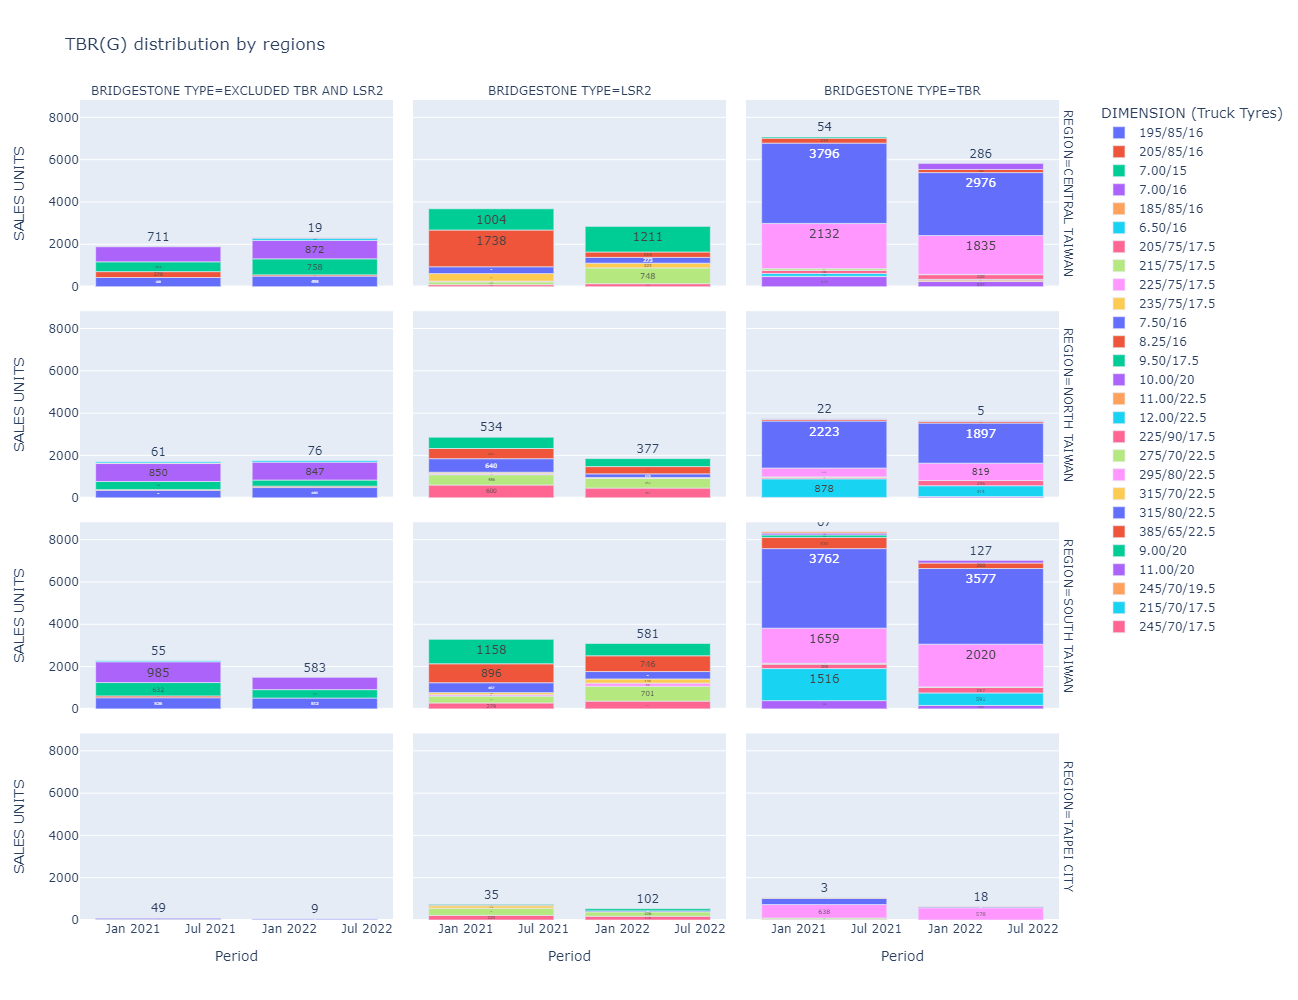

In [149]:
px.bar(mar_group, x="Period", y="SALES UNITS", color="DIMENSION (Truck Tyres)", facet_col="BRIDGESTONE TYPE", facet_row="REGION", height=1000, text="SALES UNITS", title="TBR(G) distribution by regions")

In [142]:
mar_data_bs = df[((df["Period"] == "2022-03-22") | (df["Period"] == "2021-03-22")) & (df["BRAND"] == "BRIDGESTONE")]

In [143]:
mar_group_bs = mar_data_bs.groupby([pd.Grouper(key="Period", freq="MS"), "BRIDGESTONE TYPE", "REGION", "DIMENSION (Truck Tyres)"])[["SALES UNITS"]].sum().reset_index()

In [146]:
px.bar(mar_group_bs, x="Period", y="SALES UNITS", color="DIMENSION (Truck Tyres)", facet_col="BRIDGESTONE TYPE", facet_row="REGION", height=1000, text="SALES UNITS", title="TBR(G) BS distribution by regions")

In [155]:
total_trend = df.groupby([pd.Grouper(key="Period", freq="MS"), "BRIDGESTONE TYPE", "REGION"])[["SALES UNITS"]].sum().reset_index()

In [161]:
total_trend

Period       BRIDGESTONE TYPE          REGION  SALES UNITS
0   2021-01-01  EXCLUDED TBR AND LSR2  CENTRAL TAIWAN         1915
1   2021-01-01  EXCLUDED TBR AND LSR2    NORTH TAIWAN         1709
2   2021-01-01  EXCLUDED TBR AND LSR2    SOUTH TAIWAN         1962
3   2021-01-01  EXCLUDED TBR AND LSR2     TAIPEI CITY           70
4   2021-01-01                   LSR2  CENTRAL TAIWAN         3740
..         ...                    ...             ...          ...
174 2022-03-01                   LSR2     TAIPEI CITY          534
175 2022-03-01                    TBR  CENTRAL TAIWAN         5823
176 2022-03-01                    TBR    NORTH TAIWAN         3643
177 2022-03-01                    TBR    SOUTH TAIWAN         7022
178 2022-03-01                    TBR     TAIPEI CITY          642

[179 rows x 4 columns]

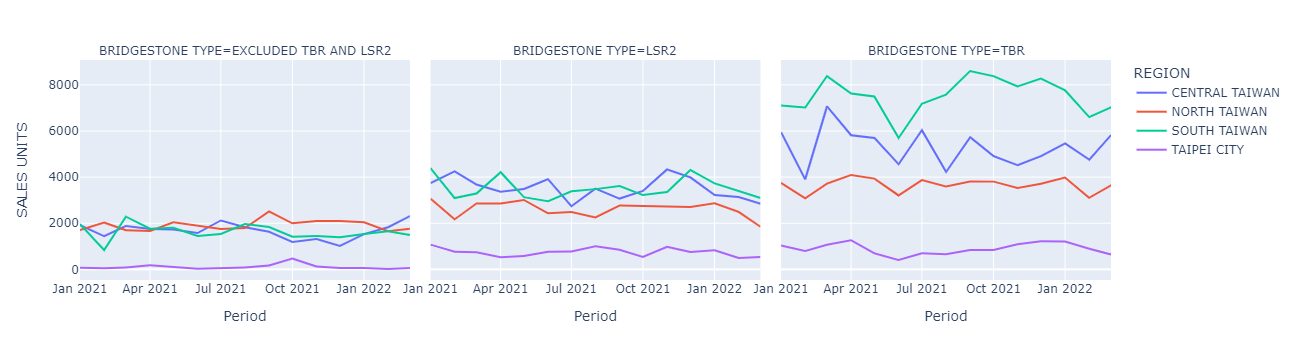

In [156]:
px.line(total_trend, x="Period", y="SALES UNITS", color="REGION", facet_col="BRIDGESTONE TYPE")

In [169]:
bs_trend = df[df["BRAND"] == "BRIDGESTONE"]

In [170]:
bs_trend = bs_trend.groupby([pd.Grouper(key="Period", freq="MS"), "BRIDGESTONE TYPE", "REGION"])[["SALES UNITS"]].sum().reset_index()

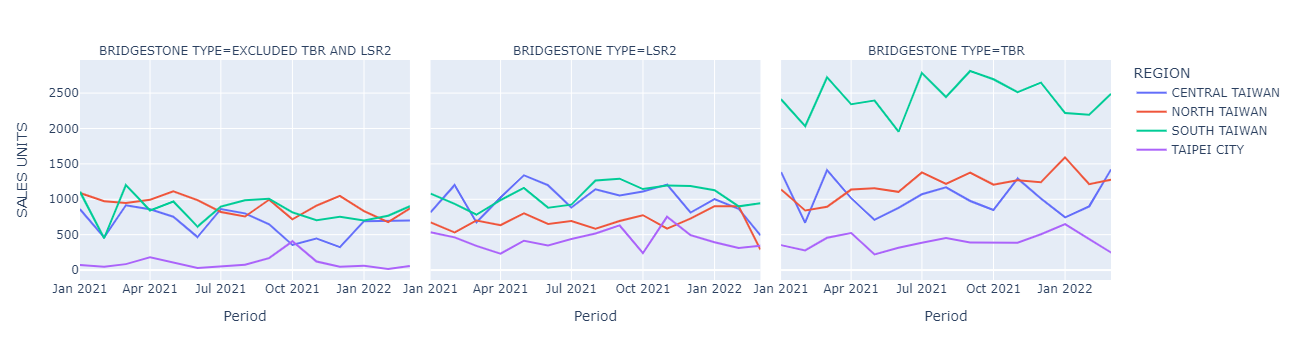

In [171]:
px.line(bs_trend, x="Period", y="SALES UNITS", color="REGION", facet_col="BRIDGESTONE TYPE")